[-38, -38, -40, -38, -38, -33, -38, -36, -34, -38, -36, -35, -38, -36, -38, -38, -36, -38, -39, -36, -38, -38, -38, -36, -40, -38, -38, -38, -41, -39, -38, -38, -36, -35, -36, -38, -38, -40, -38, -35, -36, -36, -37, -38, -36, -40, -40, -38, -38, -40, -41, -37, -38, -38, -39, -39, -36, -36, -38, -37, -36, -36, -36, -39, -38, -36]


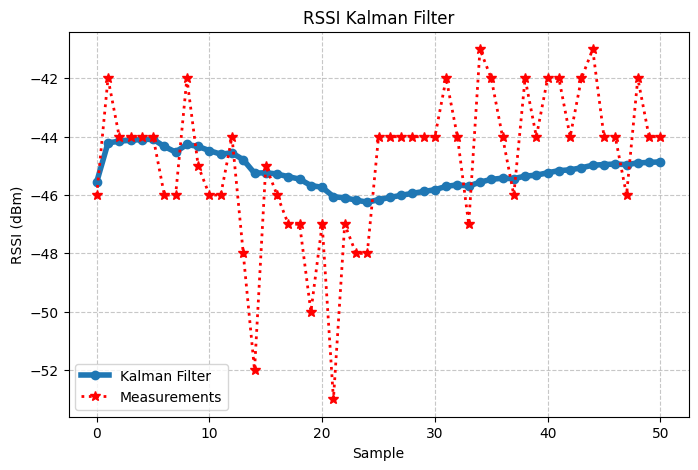

[8.737801147687724, 7.5441013333910405, 7.496446388852997, 7.469431394031218, 7.452034252340287, 7.439894920230843, 7.646773995010999, 7.809711706524648, 7.588921844353685, 7.646472770824262, 7.76713785098427, 7.870197640535615, 7.832554901228654, 8.036927042091468, 8.452818170935286, 8.438935488837712, 8.479085540026844, 8.565231696682382, 8.643354812058599, 8.854257881042804, 8.913849575250214, 9.232474536634466, 9.272923994923646, 9.35169552710836, 9.424917351943995, 9.338414374620358, 9.258878850584988, 9.185504157462844, 9.117603231883699, 9.054587259036683, 8.995948754589698, 8.881479071637445, 8.832435547949958, 8.870161568745612, 8.743304375567968, 8.650844981384159, 8.614155960039936, 8.628257227670836, 8.546739345088827, 8.515697850714982, 8.441750699989697, 8.371869080251145, 8.347501669794205, 8.283566124530315, 8.203190953339798, 8.184418262379184, 8.166473838911875, 8.1860681383191, 8.132859948558911, 8.117096398659221, 8.101972072971321]
Mean Value of distance: 8.4262496

In [1]:
#Step1: Extract and filter the data 
import numpy as np
import matplotlib.pyplot as plt
import json
import statistics
# Replace 'your_file.json' with the path to your actual .json file
file_path = 'Data File/3m_dis(16).json'

with open(file_path, 'r') as file:
    data = json.load(file)
# Initialize an empty array to store RSSI values
rssi_values = []

# Specific gatewayID to look for
specific_gateway_id = "rB8J//4G/PI="

# Loop through each item in the data list
for item in data:
    # Check if 'rxInfo' is present in the item's payload
    if 'rxInfo' in item["payload"]:
        # Access the list of rxInfo within the payload
        rx_info_list = item["payload"]["rxInfo"]
        # Loop through each rxInfo item
        for rx_info in rx_info_list:
            # Check if the gatewayID matches the specific one we're looking for
            if rx_info["gatewayID"] == specific_gateway_id:
                # If it matches, append the rssi value to the rssi_values list
                rssi_values.append(rx_info["rssi"])

# At this point, rssi_values contains the RSSI values for the specific gatewayID
print(rssi_values)
##############################################################################################################################################
#Filter the raw RSSI data using kalman
Xsaved_values = []
rssi_values= [-46, -42, -44, -44, -44, -44, -46, -46, -42, -45, -46, -46, -44, -48, -52, -45, -46, -47, -47, -50, -47, -53, -47, -48, -48, -44, -44, -44, -44, -44, -44, -42, -44, -47, -41, -42, -44, -46, -42, -44, -42, -42, -44, -42, -41, -44, -44, -46, -42, -44, -44]
# Calculate std deviation, variance(R) and mean value of raw RSSI value
std_dev = statistics.stdev(rssi_values)
T_value=std_dev # calculate T value
variance = pow(std_dev,2)
mean_value = np.mean(rssi_values)

# Define the Kalman filter parameters and initial values
A = 1
H = 1

# System and measurement error variables
Q = 0
R = variance  # standard deviation square # variance

# The initial values and the error of those
x = mean_value # the average of the data set
P = 10 #unchanged
firstRun = True

def SimpleKalman(z):
    global A, H, Q, R, x, P, firstRun

    if firstRun:
        firstRun = False

    # Kalman algorithm
    xp = A * x  # I. Prediction of estimate
    Pp = A * P * A + Q  # Prediction of error cov

    K = Pp * H / (H * Pp * H + R)  # II. Computation of Kalman gain

    x = xp + K * (z - H * xp)  # III. Comp. of state estimate
    P = Pp - K * H * Pp  # IV. Comp. of error cov.

    return x

# Calculate the number of samples based on the dataset
Nsamples = len(rssi_values)

Xsaved = np.zeros(Nsamples)
Zsaved = np.zeros(Nsamples)

# Simulate Kalman filter with the provided dataset
for k in range(Nsamples):
    z = rssi_values[k]
    filteredRSSI = SimpleKalman(z)

    Xsaved[k] = filteredRSSI
    Zsaved[k] = z
    Xsaved_values.append(filteredRSSI)

# Create a line plot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
t = range(Nsamples)  # Generate a simple time axis
ax.plot(t, Xsaved, 'o-', linewidth=4, label='Kalman Filter')
ax.plot(t, Zsaved, 'r:*', markersize=7, linewidth=2, label='Measurements')
ax.set_xlabel('Sample')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('RSSI Kalman Filter')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

#Save the plot with a white background
#fig.savefig("testing_rssi_kalman_filter_7.5_meters.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
####################################################################################################

#CALCULATE THE DISTANCE FROM THE FILTERED RSSI 
dis = []
#to calculate the distance of > 7m we must take the new Po (the reference value of rssi at 5m)
fitlered_na_values_indoor= 2.1030760655842284 #2.5028614409891765 #previously calculated indoor
for i in range(len(Xsaved_values)):
    k = (Xsaved_values[i] - (-43) - T_value )/(-10*fitlered_na_values_indoor) #-40.9 for 5m and -29.1 for 1m 
    kpow = pow(10,k)*5
    dis.append(kpow)
print(dis)
#########################################

dis_noT = []
for i in range(len(Xsaved_values)):
    k_noT = (Xsaved_values[i] - (-43))/(-10*fitlered_na_values_indoor) #-40.9 for 5m and -29.1 for 1m 
    kpow_noT = pow(10,k_noT)*5
    dis_noT.append(kpow_noT)

real_distance = 7
mean_distance = np.mean(dis)
print("Mean Value of distance:", mean_distance)
print("Mean distance with no T: ",np.mean(dis_noT))
print("Real distance: ", real_distance)
print("STD= ", std_dev)
print("Mean raw RSSI value: ", mean_value)
print("Percentage Error: ", (abs(mean_distance-real_distance)/real_distance)*100, "%")
print("Direct error: ", abs(mean_distance-real_distance))

[-81, -83, -90, -86, -83, -83, -84, -76, -84, -83, -87, -84, -80, -95, -78, -78, -80, -81, -88, -78, -78, -85, -83, -81, -78, -75, -83, -82, -80, -81, -82, -86, -84, -83, -82, -88, -81, -78, -82, -80, -89, -89, -84, -81, -94, -83, -83, -86, -83, -75, -91, -86]
Mean Value of distance: 81.05268875140904
Mean distance with no T:  55.83888281223066
Real distance:  90
STD=  4.320319244111565
Mean raw RSSI value:  -83.03846153846153
Percentage Error:  9.94145694287885 %
Direct error:  8.947311248590964


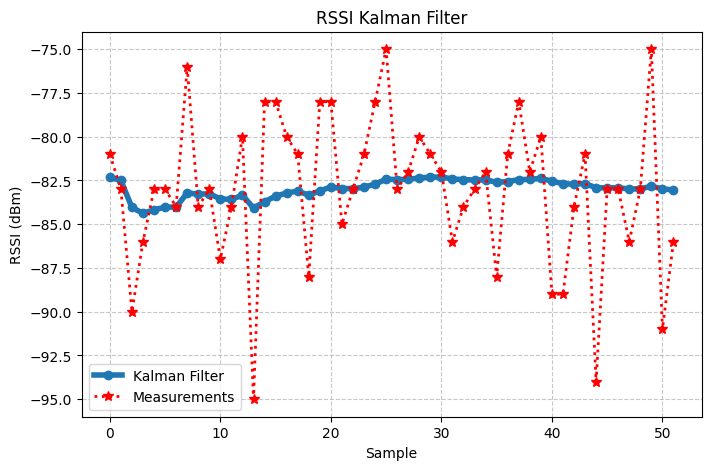

In [2]:
#Step1: Extract and filter the data 
import numpy as np
import matplotlib.pyplot as plt
import json
import statistics
# Replace 'your_file.json' with the path to your actual .json file
file_path = 'Data File/72.2m(2).json'

with open(file_path, 'r') as file:
    data = json.load(file)
# Initialize an empty array to store RSSI values
rssi_values = []

# Specific gatewayID to look for
specific_gateway_id = "rB8J//4G/PI="

# Loop through each item in the data list
for item in data:
    # Check if 'rxInfo' is present in the item's payload
    if 'rxInfo' in item["payload"]:
        # Access the list of rxInfo within the payload
        rx_info_list = item["payload"]["rxInfo"]
        # Loop through each rxInfo item
        for rx_info in rx_info_list:
            # Check if the gatewayID matches the specific one we're looking for
            if rx_info["gatewayID"] == specific_gateway_id:
                # If it matches, append the rssi value to the rssi_values list
                rssi_values.append(rx_info["rssi"])

# At this point, rssi_values contains the RSSI values for the specific gatewayID
print(rssi_values)
##############################################################################################################################################
#Filter the raw RSSI data using kalman
Xsaved_values = []

# Calculate std deviation, variance(R) and mean value of raw RSSI value
std_dev = statistics.stdev(rssi_values)
T_value=std_dev # calculate T value
variance = pow(std_dev,2)
mean_value = np.mean(rssi_values)

# Define the Kalman filter parameters and initial values
A = 1
H = 1

# System and measurement error variables
Q = 0
R = variance  # standard deviation square # variance

# The initial values and the error of those
x = mean_value # the average of the data set
P = 10 #unchange
firstRun = True

def SimpleKalman(z):
    global A, H, Q, R, x, P, firstRun

    if firstRun:
        firstRun = False

    # Kalman algorithm
    xp = A * x  # I. Prediction of estimate
    Pp = A * P * A + Q  # Prediction of error cov

    K = Pp * H / (H * Pp * H + R)  # II. Computation of Kalman gain

    x = xp + K * (z - H * xp)  # III. Comp. of state estimate
    P = Pp - K * H * Pp  # IV. Comp. of error cov.

    return x

# Calculate the number of samples based on the dataset
Nsamples = len(rssi_values)

Xsaved = np.zeros(Nsamples)
Zsaved = np.zeros(Nsamples)

# Simulate Kalman filter with the provided dataset
for k in range(Nsamples):
    z = rssi_values[k]
    filteredRSSI = SimpleKalman(z)

    Xsaved[k] = filteredRSSI
    Zsaved[k] = z
    Xsaved_values.append(filteredRSSI)

# Create a line plot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
t = range(Nsamples)  # Generate a simple time axis
ax.plot(t, Xsaved, 'o-', linewidth=4, label='Kalman Filter')
ax.plot(t, Zsaved, 'r:*', markersize=7, linewidth=2, label='Measurements')
ax.set_xlabel('Sample')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('RSSI Kalman Filter')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

#Save the plot with a white background
#fig.savefig("testing_rssi_kalman_filter_7.5_meters.png", dpi=300, bbox_inches='tight', facecolor='white')
####################################################################################################

#CALCULATE THE DISTANCE FROM THE FILTERED RSSI (7.5 meters)
dis = []
fitlered_na_values_outdoor= 2.669653591426876 #2.5028614409891765 #previously calculated indoor
for i in range(len(Xsaved_values)):
    k = (Xsaved_values[i] - (-74.47749507304725) - T_value )/(-10*fitlered_na_values_outdoor)
    kpow = pow(10,k)*26.8
    dis.append(kpow)

#########################################

dis_noT = []
for i in range(len(Xsaved_values)):
    k_noT = (Xsaved_values[i] - (-74.47749507304725))/(-10*fitlered_na_values_outdoor) 
    kpow_noT = pow(10,k_noT)*26.8
    dis_noT.append(kpow_noT)

real_distance = 90
mean_distance = np.mean(dis)
print("Mean Value of distance:", mean_distance)
print("Mean distance with no T: ",np.mean(dis_noT))
print("Real distance: ", real_distance)
print("STD= ", std_dev)
print("Mean raw RSSI value: ", mean_value)
print("Percentage Error: ", (abs(mean_distance-real_distance)/real_distance)*100, "%")
print("Direct error: ", abs(mean_distance-real_distance))

In [3]:
import json
import statistics
import numpy as np

# List of tuples, each containing the file path and the associated double number
files_and_numbers = [
    ('path/to/file1.json', 2.5),
    ('path/to/file2.json', 3.0),
    # Add more tuples for each JSON file and its associated double number
]

# Specific gatewayID to look for
specific_gateway_id = "rB8J//4G/PI="

# Function to encapsulate your provided calculation logic
def process_file_and_calculate(file_path, T_value):
    # Load JSON data from file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Your provided calculation logic starts here
    # Initialize an empty array to store RSSI values
    rssi_values = []

    # Loop through each item in the data list
    for item in data:
        # Check if 'rxInfo' is present in the item's payload
        if 'rxInfo' in item["payload"]:
            # Access the list of rxInfo within the payload
            rx_info_list = item["payload"]["rxInfo"]
            # Loop through each rxInfo item
            for rx_info in rx_info_list:
                # Check if the gatewayID matches the specific one we're looking for
                if rx_info["gatewayID"] == specific_gateway_id:
                    # If it matches, append the rssi value to the rssi_values list
                    rssi_values.append(rx_info["rssi"])

    # Make sure rssi_values is not empty before proceeding
    if not rssi_values:
        return "No RSSI values found for the specified gateway."

    # Calculate std deviation, variance(R) and mean value of raw RSSI value
    std_dev = statistics.stdev(rssi_values)
    variance = pow(std_dev, 2)
    mean_value = np.mean(rssi_values)

    # Define the Kalman filter parameters and initial values
    A = 1
    H = 1
    Q = 0
    R = variance  # variance
    x = mean_value  # the average of the dataset
    P = 10
    firstRun = True

    def SimpleKalman(z):
        nonlocal A, H, Q, R, x, P, firstRun
        if firstRun:
            firstRun = False

        xp = A * x
        Pp = A * P * A + Q

        K = Pp * H / (H * Pp * H + R)

        x = xp + K * (z - H * xp)
        P = Pp - K * H * Pp

        return x

    Xsaved_values = [SimpleKalman(z) for z in rssi_values]

    # Calculate the distance from the filtered RSSI
    dis = []
    filtered_na_values_outdoor = 2.669653591426876  # Previously calculated
    for filteredRSSI in Xsaved_values:
        k = (filteredRSSI - (-74.47749507304725) - T_value) / (-10 * filtered_na_values_outdoor)
        kpow = pow(10, k) * 26.8
        dis.append(kpow)

    mean_distance = np.mean(dis)
    return mean_distance

# Loop through each tuple in the list and process the file
for file_path, number in files_and_numbers:
    mean_distance = process_file_and_calculate(file_path, number)
    print(f"Mean distance for {file_path}: {mean_distance}")


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/file1.json'

In [ ]:
# Initialize an empty array to store RSSI values
rssi_values = []

# Specific gatewayID to look for
specific_gateway_id = "rB8J//4G/PI="

# Loop through each item in the data list
for item in data:
    # Check if 'rxInfo' is present in the item's payload
    if 'rxInfo' in item["payload"]:
        # Access the list of rxInfo within the payload
        rx_info_list = item["payload"]["rxInfo"]
        # Loop through each rxInfo item
        for rx_info in rx_info_list:
            # Check if the gatewayID matches the specific one we're looking for
            if rx_info["gatewayID"] == specific_gateway_id:
                # If it matches, append the rssi value to the rssi_values list
                rssi_values.append(rx_info["rssi"])

##############################################################################################################################################
#Filter the raw RSSI data using kalman
Xsaved_values = []

# Calculate std deviation, variance(R) and mean value of raw RSSI value
std_dev = statistics.stdev(rssi_values)
T_value=std_dev # calculate T value
variance = pow(std_dev,2)
mean_value = np.mean(rssi_values)

# Define the Kalman filter parameters and initial values
A = 1
H = 1

# System and measurement error variables
Q = 0
R = variance  # standard deviation square # variance

# The initial values and the error of those
x = mean_value # the average of the data set
P = 10 #unchange
firstRun = True

def SimpleKalman(z):
    global A, H, Q, R, x, P, firstRun

    if firstRun:
        firstRun = False

    # Kalman algorithm
    xp = A * x  # I. Prediction of estimate
    Pp = A * P * A + Q  # Prediction of error cov

    K = Pp * H / (H * Pp * H + R)  # II. Computation of Kalman gain

    x = xp + K * (z - H * xp)  # III. Comp. of state estimate
    P = Pp - K * H * Pp  # IV. Comp. of error cov.

    return x

# Calculate the number of samples based on the dataset
Nsamples = len(rssi_values)

Xsaved = np.zeros(Nsamples)
Zsaved = np.zeros(Nsamples)

# Simulate Kalman filter with the provided dataset
for k in range(Nsamples):
    z = rssi_values[k]
    filteredRSSI = SimpleKalman(z)

    Xsaved[k] = filteredRSSI
    Zsaved[k] = z
    Xsaved_values.append(filteredRSSI)

####################################################################################################

#CALCULATE THE DISTANCE FROM THE FILTERED RSSI 
dis = []
fitlered_na_values_outdoor= 2.669653591426876 #previously calculated indoor
for i in range(len(Xsaved_values)):
    k = (Xsaved_values[i] - (-74.47749507304725) - T_value )/(-10*fitlered_na_values_outdoor)
    kpow = pow(10,k)*26.8
    dis.append(kpow)
#########################################
mean_distance = np.mean(dis)
return mean_distance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Direct error with T values
direct_error_no_T = [
    1.6572864913851416,
    0.7520150446294105,
    1.0798078175244043,
    0.5848833445896167,
    1.9954221044984904,
    2.0776106262424416,
    1.260313820732318,
    0.3783743171983556,
    0.5802795693771059,
    1.7334316283427238,
    1.2940792838390612,
    1.085673518765866,
    1.0748175607570827,
    1.314887858683445,
    0.5043350367206511,
    0.5114365977326332,
    1.3894579502180722,
    0.11523811434153245,
    0.3761503393331084,
    2.1521553030830817,
    1.8778294962795953,
    1.6572864913851416,
    0.7520150446294105,
    1.0798078175244043,
    0.5848833445896167,
    1.9954221044984904,
    2.0776106262424416,
    1.260313820732318,
    0.3783743171983556,
    0.5802795693771059,
    1.7334316283427238,
    1.2940792838390612,
    1.085673518765866,
    1.0748175607570827,
    1.314887858683445,
    0.5043350367206511,
    0.5114365977326332,
    1.3894579502180722,
    0.11523811434153245,
    0.3761503393331084,
    2.1521553030830817,
    1.8778294962795953,
    0.5,
    0.53,
    0.79,
    0.76,
    0.72,
    0.7,
    1.926,
    1.92
]

# Sort the direct error with T values
direct_error_no_T_sorted = np.sort(direct_error_no_T)

# Calculate the CDF for direct error with T values
cdf_direct_error_no_T = np.arange(1, len(direct_error_no_T_sorted) + 1) / len(direct_error_no_T_sorted)

# Direct errors values
direct_errors = [
    0.7665909080855275,
    0.507347044183728,
    1.9089478901940504,
    1.1297339736074594,
    0.3484139652842524,
    0.9421767229471354,
    0.26196810564735884,
    0.540987515306731,
    0.022223546556614515,
    0.7405170528987375,
    0.5079075775992319,
    0.4782253297031067,
    0.5390323343137053,
    0.5444071604011196,
    0.12116474283364997,
    0.02813224536066672,
    0.18085182100303676,
    0.22270091358924748,
    0.6456616623595055,
    1.193618861260756,
    0.7197092487462609,
    0.7665909080855275,
    0.507347044183728,
    1.9089478901940504,
    1.1297339736074594,
    0.3484139652842524,
    0.9421767229471354,
    0.26196810564735884,
    0.540987515306731,
    0.022223546556614515,
    0.7405170528987375,
    0.5079075775992319,
    0.4782253297031067,
    0.5390323343137053,
    0.5444071604011196,
    0.12116474283364997,
    0.02813224536066672,
    0.18085182100303676,
    0.22270091358924748,
    0.6456616623595055,
    1.193618861260756,
    0.7197092487462609,
    0.324,
    0.32,
    0.21,
    0.2,
    0.126,
    0.12,
    1.15,
    1.1
]

# Sort the direct errors values
direct_errors_sorted = np.sort(direct_errors)

# Calculate the CDF for direct errors values
cdf_direct_errors = np.arange(1, len(direct_errors_sorted) + 1) / len(direct_errors_sorted)

# Generate more data points for smoother plotting
x_smooth = np.linspace(min(direct_error_no_T_sorted.min(), direct_errors_sorted.min()),
                       max(direct_error_no_T_sorted.max(), direct_errors_sorted.max()), 10)

# Interpolate CDF values for direct error with T values
cdf_direct_error_no_T_smooth = np.interp(x_smooth, direct_error_no_T_sorted, cdf_direct_error_no_T)

# Interpolate CDF values for direct errors values
cdf_direct_errors_smooth = np.interp(x_smooth, direct_errors_sorted, cdf_direct_errors)

# Plotting the CDF
plt.plot(x_smooth, cdf_direct_error_no_T_smooth, label='Direct Error no T', color='blue', linestyle='-')
plt.plot(x_smooth, cdf_direct_errors_smooth, label='Direct Errors with T', color='red', linestyle='-')
plt.xlabel('Error (m)')
plt.ylabel('CDF (%)')
plt.title('Cumulative Distribution Function (CDF)')
plt.legend()
plt.grid(True)

# Plotting the CDF
plt.plot(x_smooth, cdf_direct_error_no_T_smooth, label='Direct Error with T', color='blue', linestyle='-')
plt.plot(x_smooth, cdf_direct_errors_smooth, label='Direct Errors', color='red', linestyle='-')

# Draw a horizontal line at y=0.9
plt.axhline(y=0.9, color='black', linestyle='--', linewidth=2)

# Draw vertical lines at the intersection points
plt.axvline(x=1.08, color='black', linestyle='--', linewidth=1)
plt.axvline(x=1.98, color='black', linestyle='--', linewidth=1)


# Set background color to white
plt.gca().set_facecolor('white')

# Save the plot as an image
plt.savefig('CDF_plot2.png', bbox_inches='tight', dpi=300)
plt.show()

print(np.mean(direct_errors))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
direct_errors = [
    1.9420877592923844,
    3.5222665438083354,
    1.3795350866334175,
    5.469210376238102,
    6.016981049024018,
    6.138973736858716,
    3.4791996650629784,
    1.9023265460914587,
    5.975252720198057,
    5.19706724638683,
    5.768013062980046,
    0.5766841329767161,
    4.568013062980043,
    7.448618917930673,
    1.9023265460914587,
    7.44386727658091,
    1.7524467624646434,
    7.052688751409036,
    5.443893261054768,
    7.6,
    8.5,
    6.5,
    1.9420877592923844,
    3.5222665438083354,
    1.3795350866334175,
    5.469210376238102,
    6.016981049024018,
    6.138973736858716,
    3.4791996650629784,
    1.9023265460914587,
    5.975252720198057,
    5.19706724638683,
    5.768013062980046,
    0.5766841329767161,
    4.568013062980043,
    7.448618917930673,
    1.9023265460914587,
    7.44386727658091,
    1.7524467624646434,
    7.052688751409036,
    5.443893261054768,
    7.6,
    8.5,
    6.5
]

direct_error_no_T = [
    30.5 - 23.61415253165784,
    40 - 27.901509370341348,
    47.3 - 35.44634227632094,
    55 - 39.18255134364904,
    63 - 47.69269555894793,
    90.7 - 69.2434298701628,
    40 - 27.897167353703693,
    43.2 - 33.140582383313,
    42 - 30.618909915999545,
    42 - 31.073938564440063,
    42 - 37.945327786865036,
    42 - 33.90798221985848,
    43.2 - 37.945327786865036,
    42 - 30.728681906496966,
    43.2 - 33.140582383313,
    60 - 35.394996922078086,
    72.2 - 50.37993678091229,
    74 - 55.83888281223066,
    90 - 69.56637320282866,
    14.3,
    18.8,
    20.2,
    30.5 - 23.61415253165784,
    40 - 27.901509370341348,
    47.3 - 35.44634227632094,
    55 - 39.18255134364904,
    63 - 47.69269555894793,
    90.7 - 69.2434298701628,
    40 - 27.897167353703693,
    43.2 - 33.140582383313,
    42 - 30.618909915999545,
    42 - 31.073938564440063,
    42 - 37.945327786865036,
    42 - 33.90798221985848,
    43.2 - 37.945327786865036,
    42 - 30.728681906496966,
    43.2 - 33.140582383313,
    60 - 35.394996922078086,
    72.2 - 50.37993678091229,
    74 - 55.83888281223066,
    90 - 69.56637320282866,
    14.3,
    18.8,
    20.2
]
direct_error_no_T_sorted = np.sort(direct_error_no_T)
cdf_direct_error_no_T = np.arange(1, len(direct_error_no_T_sorted) + 1) / len(direct_error_no_T_sorted)

# Sort the direct errors values
direct_errors_sorted = np.sort(direct_errors)

# Calculate the CDF for direct errors values
cdf_direct_errors = np.arange(1, len(direct_errors_sorted) + 1) / len(direct_errors_sorted)

# Generate more data points for smoother plotting
x_smooth = np.linspace(min(direct_error_no_T_sorted.min(), direct_errors_sorted.min()),
                       max(direct_error_no_T_sorted.max(), direct_errors_sorted.max()), 20)

# Interpolate CDF values for direct error with T values
cdf_direct_error_no_T_smooth = np.interp(x_smooth, direct_error_no_T_sorted, cdf_direct_error_no_T)

# Interpolate CDF values for direct errors values
cdf_direct_errors_smooth = np.interp(x_smooth, direct_errors_sorted, cdf_direct_errors)

# Plotting the CDF
plt.plot(x_smooth, cdf_direct_error_no_T_smooth, label='Direct Error no T', color='blue', linestyle='-')
plt.plot(x_smooth, cdf_direct_errors_smooth, label='Direct Errors with T', color='red', linestyle='-')
plt.xlabel('Error (m)')
plt.ylabel('CDF (%)')
plt.title('Cumulative Distribution Function (CDF)')
plt.legend()
plt.grid(True)

# Plotting the CDF
plt.plot(x_smooth, cdf_direct_error_no_T_smooth, label='Direct Error with T', color='blue', linestyle='-')
plt.plot(x_smooth, cdf_direct_errors_smooth, label='Direct Errors', color='red', linestyle='-')

# Draw a horizontal line at y=0.9
plt.axhline(y=0.9, color='black', linestyle='--', linewidth=2)

# Draw vertical lines at the intersection points
plt.axvline(x=7.55, color='black', linestyle='--', linewidth=1)
plt.axvline(x=21.22, color='black', linestyle='--', linewidth=1)


# Set background color to white
plt.gca().set_facecolor('white')

# Save the plot as an image
plt.savefig('CDF_plot2.png', bbox_inches='tight', dpi=300)
plt.show()

print(np.mean(direct_errors))